# Visualising the embedding space of CLIP

If you are running this notebook on Lisa:
* We assume that you have activated the **dl2** environment. You can setup this environment by using the *environment.yml* file in the same repository as this notebook, by running `conda env create -f environment.yml`.
* It is also assumed that you have set the kernel type to *ipykernel* (default).

If you are running this notebook on Colab, please uncomment and run the following cell:

In [ ]:
# !pip install ftfy regex tqdm fvcore imageio imageio-ffmpeg openai pattern
!pip install git+https://github.com/openai/CLIP.git
# !pip install -U --no-cache-dir gdown --pre
# !pip install profanity-filter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wf3nv5_6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wf3nv5_6
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [ ]:
# !nvidia-smi  # Show GPU info.
# !python -m spacy download en
# import datetime
# import json
# import re
# import time

In [ ]:
# Required packages
import os
import requests
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import openai
from PIL import Image
# from profanity_filter import ProfanityFilter
import torch

## Foundation models: CLIP

In [ ]:
clip_version = "ViT-L/14" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "RN50x64", "ViT-B/32", "ViT-B/16", "ViT-L/14"] {type:"string"}
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768, 'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]

### Download CLIP model weights and define helper functions

In [ ]:
# torch.cuda.set_per_process_memory_fraction(0.9, None)  # Only needed if session crashes.
model, preprocess = clip.load(clip_version)  # clip.available_models()
# model.cuda().eval()
if torch.cuda.is_available():
    print('Cuda available!')
    model.cuda().eval() 
else:
    print('Cuda not available, using CPU instead...')
    model.cpu().eval()

def num_params(model):
    return np.sum([int(np.prod(p.shape)) for p in model.parameters()])

print("Model parameters (total):", num_params(model))
print("Model parameters (image encoder):", num_params(model.visual))
print("Model parameters (text encoder):", num_params(model.token_embedding) + num_params(model.transformer))
print("Input image resolution:", model.visual.input_resolution)
print("Context length:", model.context_length)
print("Vocab size:", model.vocab_size)
img_size = model.visual.input_resolution

Cuda available!
Model parameters (total): 427616513
Model parameters (image encoder): 303966208
Model parameters (text encoder): 122999808
Input image resolution: 224
Context length: 77
Vocab size: 49408


### CLIP helper functions (nearest neighbor search)

In [ ]:
def get_text_feats(in_text, batch_size=64):
    if torch.cuda.is_available():
        text_tokens = clip.tokenize(in_text).cuda() 
    else: 
        text_tokens = clip.tokenize(in_text).cpu()
    
    text_id = 0
    text_feats = np.zeros((len(in_text), clip_feat_dim), dtype=np.float32)
    while text_id < len(text_tokens):  # Batched inference.
        batch_size = min(len(in_text) - text_id, batch_size)
        text_batch = text_tokens[text_id:text_id+batch_size]
        with torch.no_grad():
            batch_feats = model.encode_text(text_batch).float()
        batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
        batch_feats = np.float32(batch_feats.cpu())
        text_feats[text_id:text_id+batch_size, :] = batch_feats
        text_id += batch_size
        
    return text_feats

def get_img_feats(img):
    img_pil = Image.fromarray(np.uint8(img))
    img_in = preprocess(img_pil)[None, ...]
    with torch.no_grad():
        if torch.cuda.is_available():
            img_feats = model.encode_image(img_in.cuda()).float()
        else:
            img_feats = model.encode_image(img_in).float()
        
        img_feats /= img_feats.norm(dim=-1, keepdim=True)
        
        if torch.cuda.is_available():
            img_feats = np.float32(img_feats.cpu())
        else:
            img_feats = np.float32(img_feats)

    return img_feats

def get_nn_text(raw_texts, text_feats, img_feats):
    scores = text_feats @ img_feats.T
    scores = scores.squeeze()
    high_to_low_ids = np.argsort(scores).squeeze()[::-1]
    high_to_low_texts = [raw_texts[i] for i in high_to_low_ids]
    high_to_low_scores = np.sort(scores).squeeze()[::-1]
    return high_to_low_texts, high_to_low_scores

### Load scene categories from Places365 and compute their CLIP features

In [ ]:
# Load scene categories from Places365.
if not os.path.exists('categories_places365.txt'):
    url = "https://raw.githubusercontent.com/zhoubolei/places_devkit/master/categories_places365.txt"
    response = requests.get(url)
    with open("categories_places365.txt", "wb") as f:
        f.write(response.content)
    # ! wget https://raw.githubusercontent.com/zhoubolei/places_devkit/master/categories_places365.txt


In [ ]:
place_categories = np.loadtxt('categories_places365.txt', dtype=str)
place_texts = []
for place in place_categories[:, 0]:
    place = place.split('/')[2:]
    if len(place) > 1:
        place = place[1] + ' ' + place[0]
    else:
        place = place[0]
    place = place.replace('_', ' ')
    place_texts.append(place)
place_feats = get_text_feats([f'Photo of a {p}.' for p in place_texts])

### Load object categories from Tencent ML Images and compute their CLIP features

In [ ]:
# Load object categories from Tencent ML Images.
if not os.path.exists('dictionary_and_semantic_hierarchy.txt'):
  ! wget https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt

with open('dictionary_and_semantic_hierarchy.txt') as fid:
    object_categories = fid.readlines()
object_texts = []
# unsafe_list = []
# pf = ProfanityFilter()
for object_text in object_categories[1:]:
    object_text = object_text.strip()
    object_text = object_text.split('\t')[3]
    safe_list = ''
    for variant in object_text.split(','):
        text = variant.strip()
        # if pf.is_clean(text):
        #     safe_list += f'{text}, '
        # else:
        #     unsafe_list.append(text)
        safe_list += f'{text}, '
    safe_list = safe_list[:-2]
    if len(safe_list) > 0:
        object_texts.append(safe_list)
object_texts = [o for o in list(set(object_texts)) if o not in place_texts]  # Remove redundant categories.
object_feats = get_text_feats([f'Photo of a {o}.' for o in object_texts])

## Example: prompting with a specific image

In [ ]:
class ImageManager:
    def _init_(self):
        self.images_to_download = {
            'demo_img.png': 'https://github.com/rmokady/CLIP_prefix_caption/raw/main/Images/COCO_val2014_000000165547.jpg',
            'monkey_with_gun.jpg': 'https://drive.google.com/uc?export=download&id=1iG0TJTZ0yRJEC8dA-WwS7X-GhuX8sfy8',
            'astronaut_with_beer.jpg': 'https://drive.google.com/uc?export=download&id=1p5RwifMFtl1CLlUXaIR_y60_laDTbNMi'
        }
        self.download_data()

    def download_data(self):
        # Download images
        for img_path, img_url in self.images_to_download.items():
            if not os.path.exists(img_path):
                self.download_image_from_url(img_path, img_url)

    @staticmethod
    def download_image_from_url(img_path, img_url):
        with open(img_path, 'wb') as f:
            f.write(requests.get(img_url).content)

    @staticmethod
    def load_image(image_path):
        return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

In [ ]:
img_manager = ImageManager()

In [ ]:
# monkey_with_gun = img_manager.load_image('monkey_with_gun.jpg')

error: ignored

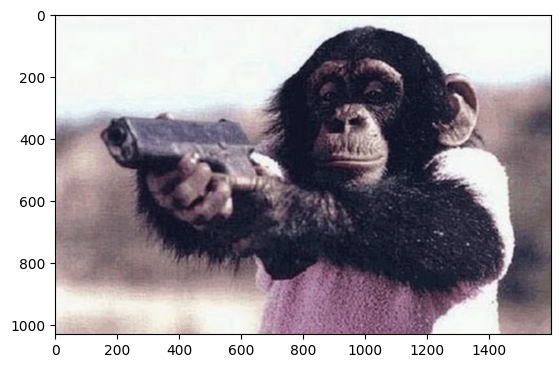

In [ ]:
# Download image.
# img_url = "https://github.com/rmokady/CLIP_prefix_caption/raw/main/Images/COCO_val2014_000000165547.jpg" #@param {type:"string"}
img_url = 'https://drive.google.com/uc?export=download&id=1iG0TJTZ0yRJEC8dA-WwS7X-GhuX8sfy8'
fname = 'demo_img.png'

# fname='test_image.jpeg'
with open(fname, 'wb') as f:
    f.write(requests.get(img_url).content)

verbose = True #@param {type:"boolean"}

# Load image.
img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img_feats = get_img_feats(img)

In [ ]:
# Knowing the dimensionality of the image features (1 img), place features (365 places) and object features (10801 objects)
print(img_feats.shape)
print(place_feats.shape)
print(object_feats.shape)

(1, 768)
(365, 768)
(10801, 768)


# Zero-shot VLM

In [ ]:
# Helper function to devise a prompt
def prompt_creator(img_type, ppl_result, sorted_places, object_list, aim='intelligent'):
    prompt = ''
    
    if aim == 'intelligent':
        prompt += f'''I am an intelligent image captioning bot. '''
    elif aim == 'generic':
        prompt += f'''Generate a caption for the following description: .'''

    prompt += f'''This image is a {img_type}. There {ppl_result}. 
    I think this photo was taken at a {sorted_places[0]}, {sorted_places[1]}, or {sorted_places[2]}.
    I think there might be a {object_list} in this {img_type}.
    A creative short caption I can generate to describe this image is:'''
    return prompt

In [ ]:
# Classify image type
img_types = ['photo', 'cartoon', 'sketch', 'painting']
img_types_feats = get_text_feats([f'This is a {t}.' for t in img_types])
sorted_img_types, img_type_scores = get_nn_text(img_types, img_types_feats, img_feats)
img_type = sorted_img_types[0]

# Classify number of people
ppl_texts = ['are no people', 'is one person', 'are two people', 'are three people', 'are several people', 'are many people']
ppl_feats = get_text_feats([f'There {p} in this photo.' for p in ppl_texts])
sorted_ppl_texts, ppl_scores = get_nn_text(ppl_texts, ppl_feats, img_feats)
ppl_result = sorted_ppl_texts[0]

# Classify places
place_topk = 3
place_feats = get_text_feats([f'Photo of a {p}.' for p in place_texts])
sorted_places, places_scores = get_nn_text(place_texts, place_feats, img_feats)

# Classify objects
obj_topk = 10
sorted_obj_texts, obj_scores = get_nn_text(object_texts, object_feats, img_feats)
object_list = ''
for i in range(obj_topk):
    object_list += f'{sorted_obj_texts[i]}, '
object_list = object_list[:-2]

# Generate captions
prompt = prompt_creator(img_type, ppl_result, sorted_places, object_list, aim='intelligent')

In [ ]:
print('The prompt generated by the VLM (CLIP) is...\n')
print(prompt)

The prompt generated by the VLM (CLIP) is...

I am an intelligent image captioning bot. This image is a photo. There is one person. 
    I think this photo was taken at a veterinarians office, art school, or pet shop.
    I think there might be a chimpanzee, chimp, Pan troglodytes, anthropoid ape, lesser ape, central chimpanzee, Pan troglodytes troglodytes, monkey, ape, simian, primate, lawgiver, lawmaker, great ape, pongid in this photo.
    A creative short caption I can generate to describe this image is:


# PCA and t-SNE on the embedding space of CLIP corresponding to object embeddings 
* For now the first 100 objects only

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Step 1: Generate CLIP embeddings for the object data
# prompt = "example prompt"
# text_data = ["example text 1", "example text 2", "example text 3"]
# model, preprocess = clip.load("ViT-B/32")
# embeddings = model.encode(preprocess(text_data), prompt=prompt)

# Every row is an embedding vector of one object
n_objects = 10801
embeddings = object_feats[:n_objects, :]
objects_to_analyse = object_texts[:n_objects]

# Sample print
print(embeddings[:4, :4])

[[-0.03669713  0.01023454  0.01540438 -0.02115255]
 [ 0.00632822  0.02929682  0.01545738 -0.01021214]
 [-0.0140309   0.00332311 -0.01770244 -0.03652818]
 [-0.04798049 -0.0030521  -0.00862523  0.01586837]]


In [ ]:
# Step 2: Normalize the embeddings
normalized_embeddings = (embeddings - np.mean(embeddings, axis=0)) / np.std(embeddings, axis=0)

# Sample print
print(normalized_embeddings[:4, :4])

[[-1.3132278  -0.2420119  -0.33445597 -0.7989713 ]
 [ 0.05320817  0.45003742 -0.33230093 -0.3801771 ]
 [-0.59337413 -0.4929289  -1.6806971  -1.3875436 ]
 [-1.6715746  -0.7243786  -1.3115855   0.61817306]]


In [ ]:
# normalized_embeddings[0, :] @ img_feats.T

In [ ]:
scores_with_image = {}

for obj in range(normalized_embeddings.shape[0]):
    scores_with_image[objects_to_analyse[obj]] = float(normalized_embeddings[obj, :] @ img_feats.T)

In [ ]:
# scores_with_image

In [ ]:
from operator import itemgetter

In [ ]:
N = 40
biggest = dict(sorted(scores_with_image.items(), key=itemgetter(1), reverse=True)[:N])


In [ ]:
search_list = list(biggest.keys())
indices = np.array([i for i in range(len(objects_to_analyse)) if objects_to_analyse[i] in search_list])


In [ ]:
normalized_embeddings = normalized_embeddings[indices, :]

In [ ]:
# Step 3: Choose the number of dimensions
num_dimensions = 3  # Set to 2 for 2D visualization

In [ ]:
# Step 4: Perform PCA or t-SNE
if num_dimensions == 2:
    print('Performing t-SNE...')

    # Use t-SNE for 2D visualization
    tsne = TSNE(n_components=num_dimensions, perplexity=5.0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
else:
    print('Performing PCA...')

    # Use PCA for higher-dimensional visualization
    pca = PCA(n_components=num_dimensions)
    reduced_embeddings = pca.fit_transform(normalized_embeddings)

Performing PCA...


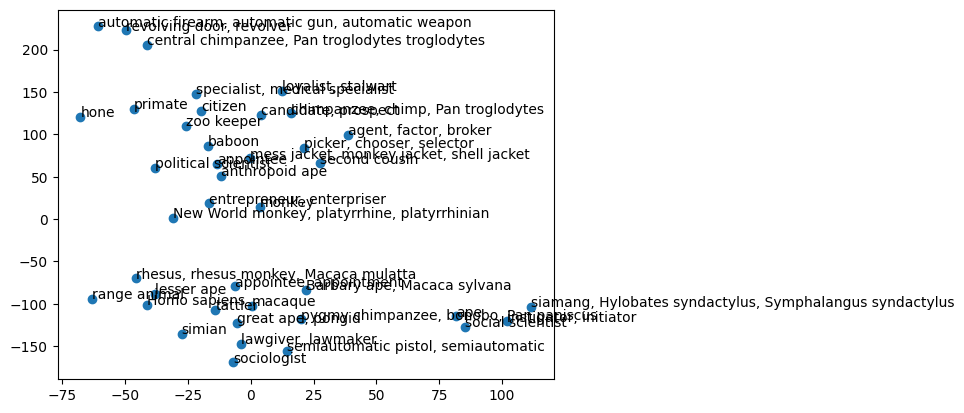

In [ ]:
# # Step 5: Visualize the results (2D)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
for i, text in enumerate(search_list):
    plt.annotate(text, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()

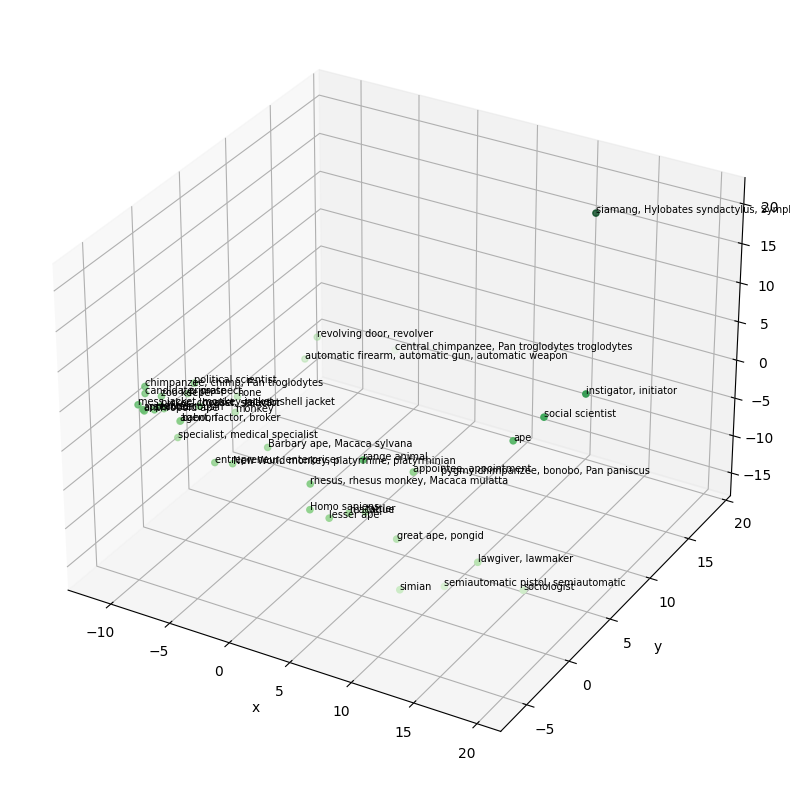

In [ ]:
# Step 5: Visualize the results (3D)
from mpl_toolkits import mplot3d
%matplotlib inline

# Use this when viewing figures interactively
# %matplotlib notebook 

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
xdata = reduced_embeddings[:, 0]
ydata = reduced_embeddings[:, 1]
zdata = reduced_embeddings[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


for i, text in enumerate(search_list):
    ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], text, fontsize=7)

Working with PCA or t-SNE would probably require us to set some threshold on the similarity between two words to determine whether they are synonyms:
* For example by taking dot product/cosine similarities between the embeddings of the two objects.

\
           
1. One way out of this is to perform clustering (k-means/Gaussian mixtures)
    * Drawback: need to set k, and this would have to be informed by the dataset for the objects/places we are using

\

2. Another possibility would be to not do a PCA or t-SNE but instead do a search through the combinations of the first n most fitting descriptor words and pick one combination that would produce the highest similarity with the image
    * Brute-force search: computationally intensive
    * Searching among the centroids created by clustering the objects

\

This method could not work for images that contain a lot of similar objects (say, three different kinds of fruit), since we would filter similar words being captioned simultaneously.